In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

import onnx
import onnxruntime

import io
import json

In [2]:
# dataset

boston_path = '../json_data/boston.json'
with open(boston_path, 'r') as f:
    boston_json = json.load(f)
    
print(type(boston_json))
for key in boston_json.keys():
    print(key, ': ', len(boston_json[key]))

<class 'dict'>
CRIM :  506
ZN :  506
INDUS :  506
CHAS :  506
NOX :  506
RM :  506
AGE :  506
DIS :  506
RAD :  506
TAX :  506
PTRATIO :  506
B :  506
LSTAT :  506
MEDV :  506


In [3]:
boston_df = pd.DataFrame.from_dict(boston_json)
print(boston_df.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [4]:
boston_np = np.array(boston_df)
print("dataset shape: ", boston_np.shape)

data_x = boston_np[:, :-1]
data_y = boston_np[:, -1].reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.25)
print("x shape: ", x_train.shape, ", ", x_test.shape)
print("y shape: ", y_train.shape, ", ", y_test.shape)

dataset shape:  (506, 14)
x shape:  (379, 13) ,  (127, 13)
y shape:  (379, 1) ,  (127, 1)


In [5]:
# norm

x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_scaler.fit(x_train)
y_scaler.fit(y_train)

x_train = x_scaler.transform(x_train)
y_train = y_scaler.transform(y_train)
x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [6]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [7]:
# dataset

class dataset(Dataset):
    
    def __init__ (self, x, y):
        self.x = x
        self.y = y
        self.data = list(zip(self.x, self.y))

    def __getitem__(self, index):
        assert index < len(self.data)
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [8]:
class boston_model(nn.Module):
    
    def __init__(self, in_layer, out_layer):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_layer, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, out_layer)
            )
        
    def forward(self, x):
        return self.linear(x)
    
model = boston_model(14, 1)
print(model)

boston_model(
  (linear): Sequential(
    (0): Linear(in_features=14, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [9]:
# # helper function for classification

def calc_acc(out, labels):
    num = out.size(0)
    prediction = out.argmax(dim=1)
    return (prediction == labels).sum().item()/num

def evaluate(model, loss_func, dataloader, method='classification'):
    loss = 0
    acc = 0

    loss = []
    acc = []
    for step, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        out = model(inputs)
        loss.append(loss_func(out, labels))
        
        if method == 'classificaiton':
            acc.append(calc_acc(out, labels))

    loss = torch.mean(torch.tensor(loss))
    
    if method == 'classificaiton':
        acc = torch.mean(torch.tensor(acc))
        return loss, acc
    elif method == 'regression':
        return loss


In [10]:
# Define a train function

def train_model(model, train_dataset, test_dataset, batch = 256, epochs = 50,
                lr = 0.005, class_weights = None, weight_decay = 0):

    # train_history
    train_history = {}
    train_history['train_loss'] = []
    train_history['test_loss'] = []

    # set device
    model = model.to(device)
    
    if class_weights != None:
        class_weights = class_weights.to(device)

    # Dataloader
    train_dl = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    test_dl = DataLoader(test_dataset, batch_size=batch, shuffle=True)
    
    # optimzer and loss_func
    optimzer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
    loss_func = nn.MSELoss()

    # train_process
    for epoch in range(epochs):
        
        for step, (inputs, labels) in enumerate(train_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            out = model(inputs)
            loss = loss_func(out, labels)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()

            # output
            train_loss = evaluate(model, loss_func, train_dl, 'regression')
            test_loss = evaluate(model, loss_func, test_dl, 'regression')
            
            print(  'Epoch:', epoch+1, '/', epochs, ', '\
                    'train_loss: {loss:.5f}, '.format(loss = train_loss), \
                    'test_loss: {loss:.5f}, '.format(loss = test_loss))

            train_history['train_loss'].append(train_loss)
            train_history['test_loss'].append(test_loss)
  
    return train_history


In [11]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
train_dataset = dataset(x_train, y_train)
test_dataset = dataset(x_test, y_test)

batch = 10000
epochs = 50
lr = 0.005

In [13]:
"""
Train Model
"""

# load model
model = boston_model(13, 1)
print(summary(model, (500, 13)))

# train
hist = train_model(model, train_dataset, test_dataset, batch, epochs, lr)

Layer (type:depth-idx)                   Output Shape              Param #
boston_model                             --                        --
├─Sequential: 1-1                        [500, 1]                  --
│    └─Linear: 2-1                       [500, 50]                 700
│    └─ReLU: 2-2                         [500, 50]                 --
│    └─Linear: 2-3                       [500, 50]                 2,550
│    └─ReLU: 2-4                         [500, 50]                 --
│    └─Linear: 2-5                       [500, 1]                  51
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
Total mult-adds (M): 1.65
Input size (MB): 0.03
Forward/backward pass size (MB): 0.40
Params size (MB): 0.01
Estimated Total Size (MB): 0.44
Epoch: 1 / 50 , train_loss: 0.84137,  test_loss: 1.06781, 
Epoch: 2 / 50 , train_loss: 0.72349,  test_loss: 0.94719, 
Epoch: 3 / 50 , train_loss: 0.62584,  test_loss: 0.84371, 
Epoch: 4 / 50 , train_loss: 0.54937,  test_lo

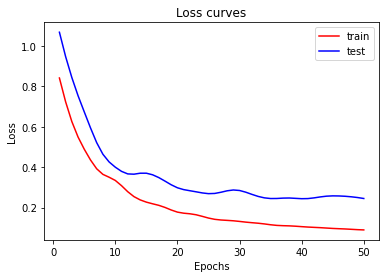

In [14]:
# Plot loss curves
epochs = range(1, len(hist['train_loss']) + 1)
plt.plot(epochs, hist['train_loss'], 'r-', label='train')
plt.plot(epochs, hist['test_loss'], 'b-', label='test')

plt.title('Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## export model to onnx

In [15]:
model = model.to('cpu')
torch_model = model.eval()
print(torch_model)

# model input
x = torch.randn(1, 13, requires_grad=True)
torch_out = torch_model(x)

boston_model(
  (linear): Sequential(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [16]:
# Export model
onnx_path = '../onnx/boston.onnx'
torch.onnx.export(model, x, onnx_path, export_params=True, do_constant_folding=True,
                  input_names=['input'], output_names=['output'])

In [17]:
# test onnx model

onnx_model = onnx.load(onnx_path)
check_res = onnx.checker.check_model(onnx_model)

In [18]:
ort_session = onnxruntime.InferenceSession(onnx_path)
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
print(ort_inputs)
ort_outs = ort_session.run(None, ort_inputs)

np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

{'input': array([[ 1.6706089 , -1.5381882 , -0.50014544, -1.1121938 ,  0.48236987,
         1.8618037 ,  0.15206745,  1.1722231 ,  0.26333523, -0.17503947,
        -1.1106174 , -0.46573517,  0.9806476 ]], dtype=float32)}


In [19]:
print(torch_out)
print(ort_outs)

tensor([[-0.4272]], grad_fn=<AddmmBackward0>)
[array([[-0.42716277]], dtype=float32)]


In [20]:
print(torch_out.size())

torch.Size([1, 1])
